### Transfer learning

In [1]:
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully u

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
print(tf. __version__)

2.9.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dir = '/content/drive/MyDrive/dataset/skin_images/train'
validation_dir = '/content/drive/MyDrive/dataset/skin_images/test'

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2637 files belonging to 2 classes.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 660 files belonging to 2 classes.


In [8]:
class_names = train_dataset.class_names

In [9]:
class_names

['benign', 'malignant']

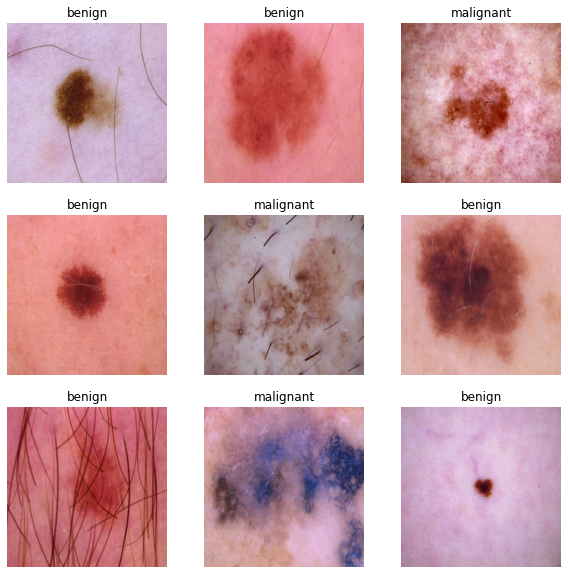

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Create test set

In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [12]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 17
Number of test batches: 4


### Configure the dataset for performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

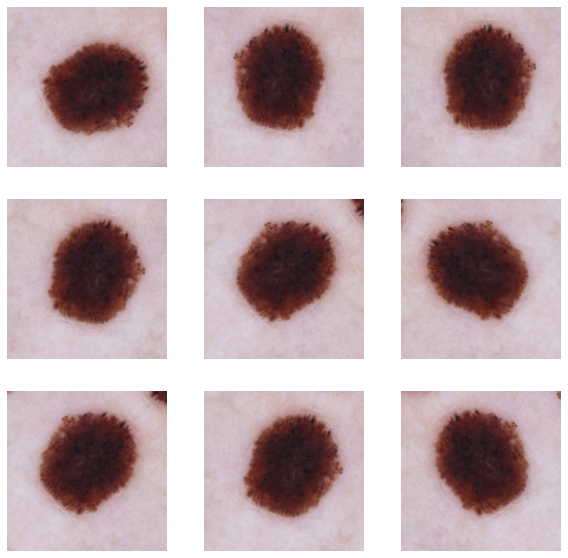

In [15]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In [16]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

### Create the base model from the pre-trained convnets

In [17]:
# Create the base model from the pre-trained model MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

87910968/87910968 [==============================] - 1s 0us/step


In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


### Feature extraction

In [19]:
base_model.trainable = False

In [20]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

### Add a classification head

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [22]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [26]:
len(model.trainable_variables)

2

### Train the model

In [27]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

17/17 [==============================] - 56s 1s/step - loss: 0.7243 - accuracy: 0.5639


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial auc: {:.2f}".format(accuracy0))

initial loss: 0.72
initial auc: 0.56


In [29]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
83/83 [==============================] - 117s 1s/step - loss: 0.6917 - accuracy: 0.5874 - val_loss: 0.6136 - val_accuracy: 0.6278
Epoch 2/10
83/83 [==============================] - 12s 139ms/step - loss: 0.6168 - accuracy: 0.6435 - val_loss: 0.5676 - val_accuracy: 0.6523
Epoch 3/10
83/83 [==============================] - 12s 131ms/step - loss: 0.5641 - accuracy: 0.7042 - val_loss: 0.5236 - val_accuracy: 0.6992
Epoch 4/10
83/83 [==============================] - 13s 152ms/step - loss: 0.5337 - accuracy: 0.7137 - val_loss: 0.5288 - val_accuracy: 0.6823
Epoch 5/10
83/83 [==============================] - 13s 152ms/step - loss: 0.5171 - accuracy: 0.7277 - val_loss: 0.4944 - val_accuracy: 0.7274
Epoch 6/10
83/83 [==============================] - 12s 144ms/step - loss: 0.5011 - accuracy: 0.7345 - val_loss: 0.4836 - val_accuracy: 0.7387
Epoch 7/10
83/83 [==============================] - 12s 129ms/step - loss: 0.4927 - accuracy: 0.7353 - val_loss: 0.4564 - val_accuracy: 0.7594
E

### Learning curves

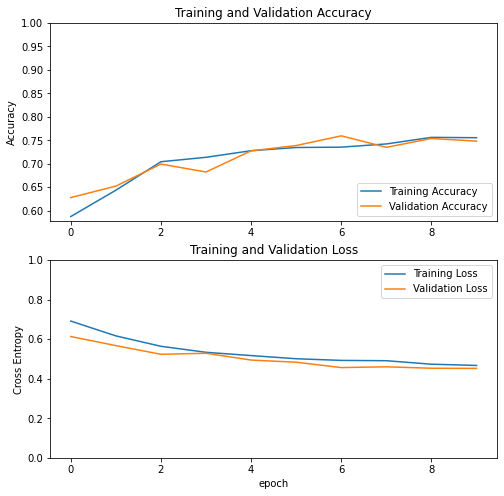

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning

### Un-freeze the top layers of the model

In [ ]:
base_model.trainable = True

In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


### Compile the model

In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [35]:
len(model.trainable_variables)

130

### Continue training the model

In [36]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
83/83 [==============================] - 36s 276ms/step - loss: 0.3971 - accuracy: 0.8051 - val_loss: 0.3507 - val_accuracy: 0.8440
Epoch 11/20
83/83 [==============================] - 20s 228ms/step - loss: 0.3090 - accuracy: 0.8574 - val_loss: 0.3406 - val_accuracy: 0.8477
Epoch 12/20
83/83 [==============================] - 20s 230ms/step - loss: 0.2584 - accuracy: 0.8836 - val_loss: 0.3475 - val_accuracy: 0.8214
Epoch 13/20
83/83 [==============================] - 20s 236ms/step - loss: 0.2504 - accuracy: 0.8805 - val_loss: 0.3410 - val_accuracy: 0.8515
Epoch 14/20
83/83 [==============================] - 21s 241ms/step - loss: 0.2093 - accuracy: 0.9060 - val_loss: 0.3139 - val_accuracy: 0.8647
Epoch 15/20
83/83 [==============================] - 20s 232ms/step - loss: 0.1957 - accuracy: 0.9086 - val_loss: 0.3351 - val_accuracy: 0.8590
Epoch 16/20
83/83 [==============================] - 20s 232ms/step - loss: 0.1760 - accuracy: 0.9166 - val_loss: 0.3541 - val_accuracy:

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

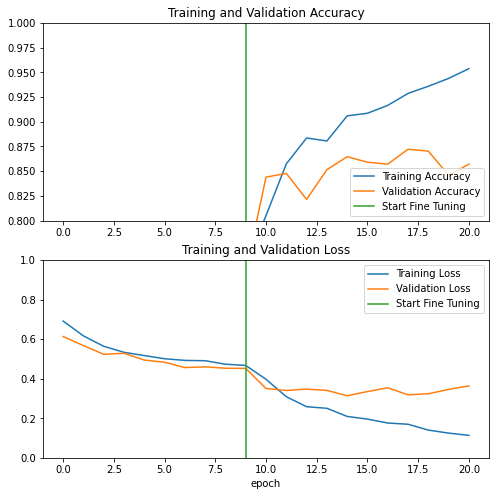

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 1s 82ms/step - loss: 0.4150 - accuracy: 0.8203
Test accuracy : 0.8203125


Predictions:
 [1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1]
Labels:
 [1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1]


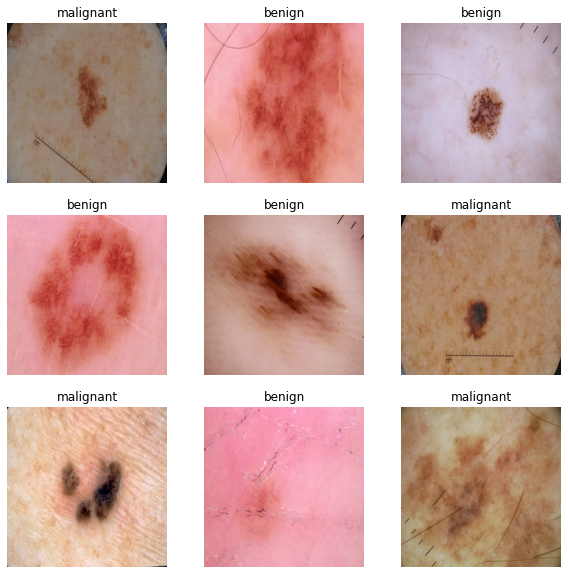

In [40]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [41]:
model.save('/content/drive/MyDrive/dataset/skin_images/inceptionv3.h5')